# Brute-Force Hyperparameter Optimization

This notebook shows how to use the *BruteForce* optimizer module together with a **Midi2Vec** *Pipeline* to evaluate a large number of *Encoder* and *SequenceLearner* hyperparameter combinations against a given training set.

* **Encoder**: trains a *Doc2Vec* model against textual representations of MIDI files and uses this model to convert MIDI files into sequences of real-valued vectors.
* **SequenceLearner**: uses a *Keras* LSTM to learn patterns in sequences of real-valued vectors and, once trained, can generate new sequences of such vectors.
* **Pipeline**: combines various **Midi2Vec** components for encoding, sequence learning and evaluation into a single interface.
* **BruteForce**: Computes and evaluates all possible hyperparameter combinations within user-specified ranges.

## Imports

In [14]:
import sys
import time
import logging
import pandas as pd
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
import math
import itertools

# Add Midi2Vec to Python working directory
sys.path.append('../')

from data_loading.data_loaders import MidiDataLoader
from midi_to_dataframe import NoteMapper
from pipeline.pipeline import Pipeline
from optimization.optimizers import BruteForce

## Logging Configuration

In [2]:
logger = logging.getLogger()
logger.level = logging.INFO
stream_handler = logging.StreamHandler(sys.stdout)
logger.addHandler(stream_handler)

# Disable Gensim (Doc2Vec) output
logging.getLogger("gensim").setLevel(logging.WARNING)

## Brute-Force Hyperparameter Sweep Values

All individual hyperparameter values to evaluate should be explicitly defined below. The *BruteForce* module will then compute all of their possible permutations and train and evaluate the corresponding modules using each computed set of parameters.

In [3]:
# Documents used to train semantic encoder model
encoder_training_docs = "../../midi-embeddings/data/full_1_measure.txt"
encoder_training_docs = "../../midi-embeddings/data/full_1_measure_100k.txt"

param_sweep_values = {

    # Encoder (doc2vec) settings:
    'doc2vec_docs': [encoder_training_docs],
    'doc2vec_dm': [1],
    'doc2vec_dm_mean': [1],
    'doc2vec_epochs': [2],
    'doc2vec_hs': [0],
    'doc2vec_learning_rate_start': [0.025],
    'doc2vec_learning_rate_end': [0.2],
    'doc2vec_min_count': [10],
    'doc2vec_negative': [0],
    'doc2vec_vector_size': [16, 20, 24],
    'doc2vec_window': [1, 5, 10],

    # Sequence learning (Keras LSTM) settings:
    'nn_features': [['bpm', 'measure', 'beat']],
    'nn_batch_size': [15, 25],
    'nn_dense_activation_function': ["linear"],
    'nn_dropout': [0, 0.05, 0.1],
    'nn_epochs': [20, 40],
    'nn_hidden_neurons': [30, 40],
    'nn_layers': [10, 15, 20],
    'nn_lstm_activation_function': ["selu"],
    'nn_lstm_n_prev': [12, 16]
}

# 'Variables' are those hyperparameters with multiple values defined
variables = []
for key, value in param_sweep_values.items():
    if len(value) > 1:
        variables.append(key)

## Define Training Documents and DataLoader 

The training documents are MIDI sequences that the **Midi2Vec** model should learn to imitate and reproduce.

In [4]:
# Define note mapper for MIDI file loading
note_mapping_config_path = "../settings/map-to-group.json"
note_mapper = NoteMapper(note_mapping_config_path)

# Data loader used to encode MIDI-format training files
data_loader = MidiDataLoader(note_mapper)

# Define training documents for sequence learning
training_docs = ["../resources/breakbeats/084 Breakthru.mid",
                 "../resources/breakbeats/086 Clouds.mid",
                 "../resources/breakbeats/089 Get Out.mid",
                 "../resources/breakbeats/089 Wrong.mid",
                 "../resources/breakbeats/090 Deceive.mid",
                 "../resources/breakbeats/090 New York.mid",
                 "../resources/breakbeats/090 Radio.mid",
                 "../resources/breakbeats/093 Pretender.mid",
                 "../resources/breakbeats/093 Right Won.mid",
                 "../resources/breakbeats/094 Run.mid"]

## Define Callback Function

This function is called after every iteration of model training. It controls outputting intermediary results and can trigger early stopping of the evaluation pipeline. Since the space of all hyperparameter combinations to evaluate can be exponentially large, it can make sense to implement reasonable early stopping criteria, i.e. after a given number of single evaluations or a predetermined amount of time.

In [5]:
results_dfs = []
runs_completed = [0]
start_time = time.time()
hours = 0.0001 #24
max_runtime = hours*60*60

def callback(params, metrics, abort):
    runs_completed[0] += 1
    merged = {**params, **metrics}
    merged['nn_features'] = ', '.join(merged['nn_features'])
    print("Completed " + str(runs_completed[0]) + " runs.")
    print(merged)
    results_dfs.append(pd.DataFrame(merged, index=[0]))
    elapsed_time = time.time() - start_time
    print(str(elapsed_time) + " seconds elapsed so far.")
    if elapsed_time >= max_runtime:
        print("Max. runtime reached.")
        abort()
        # TODO, implement proper stopping procedure instead of sys.exit
        #sys.exit(0)

## Build and Run the Pipeline

In [6]:
pipeline = Pipeline()
pipeline.set_data_loader(data_loader)
pipeline.set_training_docs(training_docs)
pipeline.set_k_fold_cross_eval(k=3)

brute_force_param_sweep = BruteForce(params=param_sweep_values)
brute_force_param_sweep.set_callback(callback)
pipeline.set_optimizer(brute_force_param_sweep)

pipeline.run()

Brute-force evaluation of 1296 hyperparameter combinations.
Loaded 100000 documents
Trained encoder model in 16.035425 seconds
Completed 1 runs.
{'doc2vec_learning_rate_end': 0.2, 'nn_batch_size': 15, 'doc2vec_hs': 0, 'nn_epochs': 20, 'doc2vec_dm': 1, 'doc2vec_min_count': 10, 'nn_hidden_neurons': 30, 'doc2vec_negative': 0, 'doc2vec_dm_mean': 1, 'doc2vec_learning_rate_start': 0.025, 'doc2vec_epochs': 2, 'doc2vec_docs': '../../midi-embeddings/data/full_1_measure_100k.txt', 'recall': 0.6362562305552261, 'nn_lstm_activation_function': 'selu', 'precision': 0.6077997062474033, 'nn_dropout': 0.1, 'nn_layers': 15, 'nn_lstm_n_prev': 12, 'f1': 0.6035200303646581, 'nn_features': 'bpm, measure, beat', 'nn_dense_activation_function': 'linear', 'doc2vec_vector_size': 16, 'doc2vec_window': 10}
335.7170581817627 seconds elapsed so far.
Max. runtime reached.


,doc2vec_dm,doc2vec_dm_mean,doc2vec_docs,doc2vec_epochs,doc2vec_hs,doc2vec_learning_rate_end,doc2vec_learning_rate_start,doc2vec_min_count,doc2vec_negative,doc2vec_vector_size,...,nn_dense_activation_function,nn_dropout,nn_epochs,nn_features,nn_hidden_neurons,nn_layers,nn_lstm_activation_function,nn_lstm_n_prev,precision,recall
0,1,1,../../midi-embeddings/data/full_1_measure_100k...,2,0,0.2,0.025,10,0,16,...,linear,0.1,20,"[bpm, measure, beat]",30,15,selu,12,0.6078,0.636256


## Collect and Aggregate Results of Runs 

In [7]:
results_df = pd.concat(results_dfs)

## Graph Single Variables (F1 Scores)

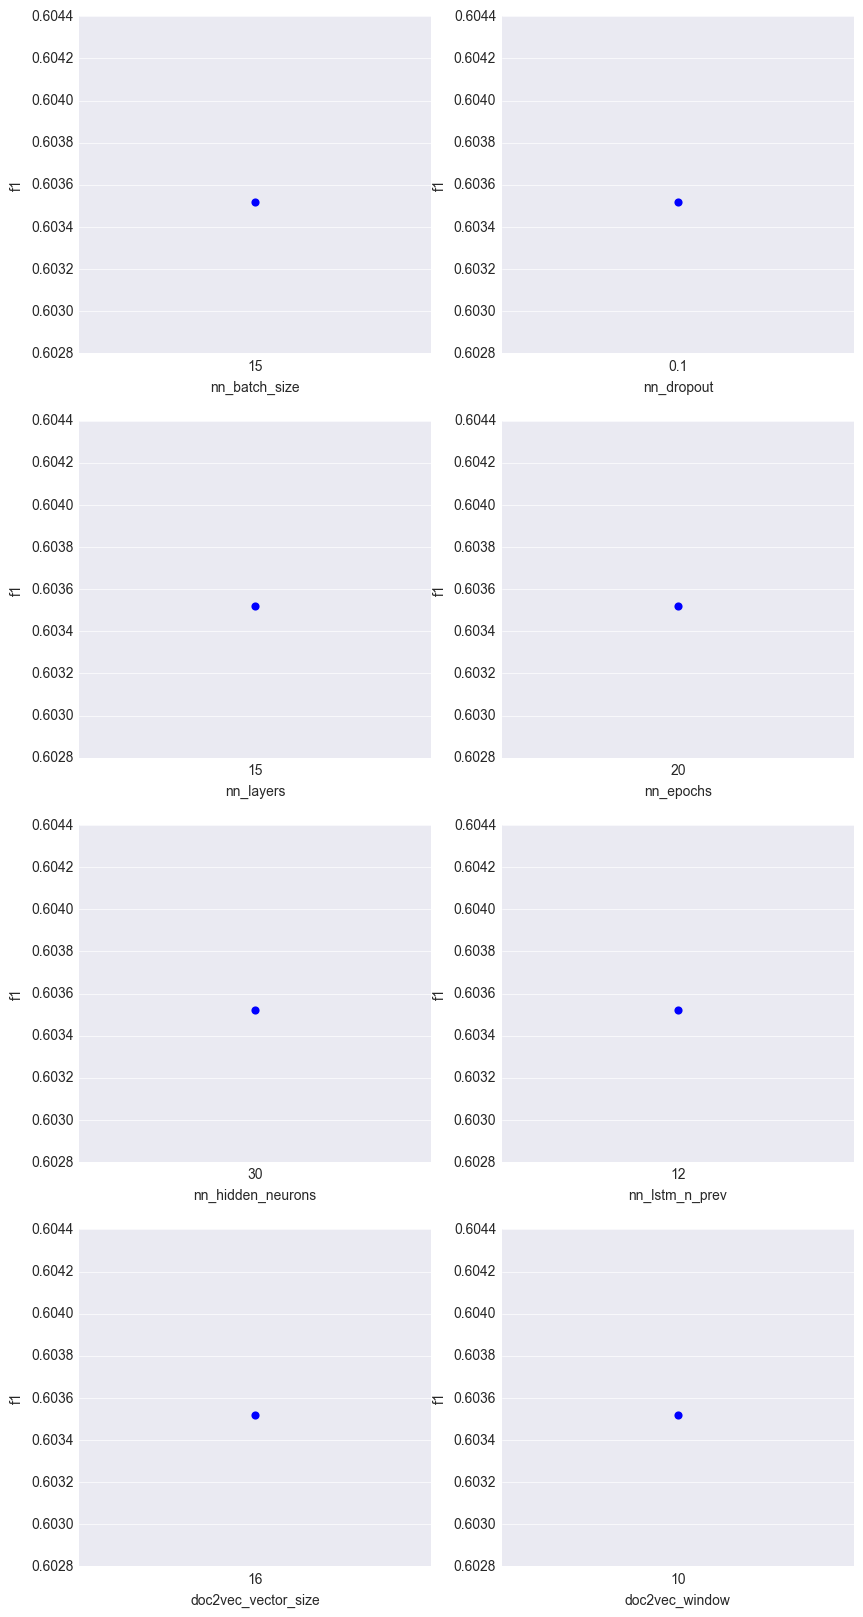

In [8]:
sns.set_style("darkgrid")

# Get number of plots to create
num_plots = len(variables)       
dim = math.ceil(num_plots / 2)

# Set up figures for plots
fig, axes = plt.subplots(dim, 2, sharex=False, sharey=False)
fig.set_size_inches(10, dim*5) # width, height

for axis_index, variable in enumerate(variables):
    grouped = results_df[[variable,'f1']].groupby([variable], as_index=False).median()
    sns.pointplot(x=variable, y='f1', data=grouped, ax=axes.flat[axis_index])

## Graph Variable Interactions (F1 Scores)

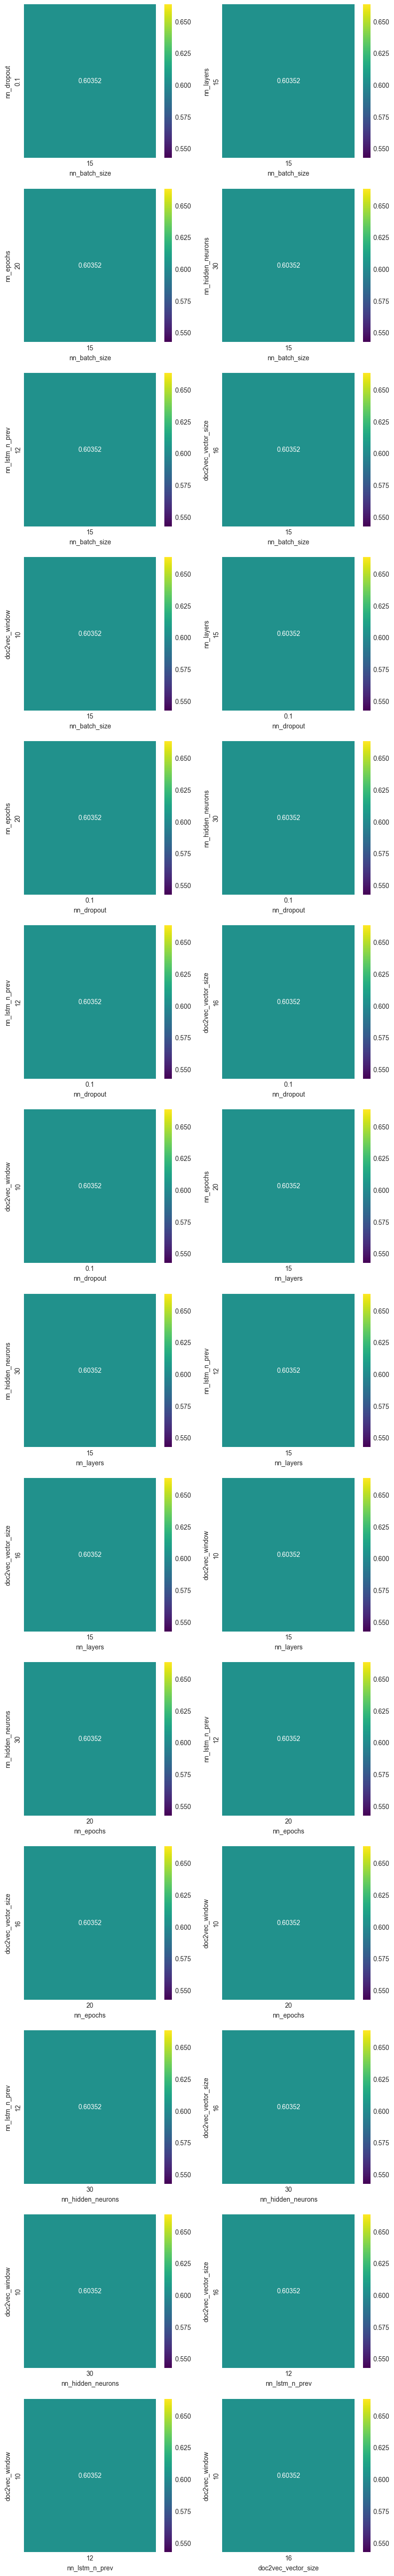

In [13]:
combinations = list(itertools.combinations(variables, r=2))
plots_per_row = 2
inches_per_plot = 5

# Number of plots to render
num_plots = len(combinations)            
dim = math.ceil(num_plots / plots_per_row)

# Set up figures for plots
fig, axes = plt.subplots(dim, plots_per_row, sharex=False, sharey=False)
fig.set_size_inches(plots_per_row * inches_per_plot, dim * inches_per_plot) # width, height

# Plot each pair of variables against each other on a heatmap
for axis_index, (heatmap_x, heatmap_y) in enumerate(combinations):
    grouped = results_df.groupby([heatmap_y, heatmap_x], as_index=False).median()
    pivoted = grouped.pivot(heatmap_y, heatmap_x, "f1")
    sns.heatmap(pivoted, annot=True, fmt="g", cmap='viridis', ax=axes.flat[axis_index])
    axis_index += 1